In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import ptitprince as pt

In [2]:
def bootstrap_statistics(df, group_col, value_col, models, stat_func=np.mean, n=1000):
    """
    Generalized bootstrapping function to calculate specified statistics for given models.
    
    Parameters:
    - df: DataFrame containing the data.
    - group_col: Column name in df that specifies the model.
    - value_col: Column name in df that specifies the value to analyze.
    - models: List of model names to analyze.
    - stat_func: Function to compute the statistic (e.g., np.mean, np.median).
    - n: Number of bootstrap samples to generate.
    
    Returns:
    - Dictionary of bootstrapped statistics for each model.
    """
    model_stats = {model: [] for model in models}
    for _ in range(n):
        for model in models:
            sample = df[df[group_col] == model][value_col].sample(frac=1, replace=True)
            model_stats[model].append(stat_func(sample))
    return model_stats


In [3]:
def plot_subplots(results, model_names, colors, percentiles=None, title_prefix=''):
    """
    Generalized function to plot results of bootstrapping with percentile lines.
    
    Parameters:
    - results: Dictionary where keys are model names and values are lists of bootstrapped statistics.
    - model_names: List of model names corresponding to keys in results.
    - colors: List of colors for each subplot.
    - percentiles: List of percentiles to mark with dashed lines (e.g., [2.5, 97.5]).
    - title_prefix: Prefix for subplot titles.
    """
    def plot_subplot(ax, data, title, color, percentiles):
        sns.histplot(data, bins=40, kde=True, color=color, ax=ax, stat="density")
        ax.set_title(title)
        ax.set_xlabel('Value')
        ax.set_ylabel('Density')
        ax.spines['top'].set_visible(True)
        ax.spines['right'].set_visible(True)
        
        # Add percentile lines if specified
        if percentiles:
            for percentile in percentiles:
                value = np.percentile(data, percentile)
                ax.axvline(x=value, color='red', linestyle='--', label=f'{percentile}th percentile')

        if percentiles:
            ax.legend()

    fig, axes = plt.subplots(len(model_names), 1, figsize=(10, 5 * len(model_names)))
    if len(model_names) == 1:
        axes = [axes] 
    
    for ax, model, color in zip(axes, model_names, colors):
        plot_subplot(ax, results[model], f'{title_prefix} {model}', color, percentiles)
    
    plt.tight_layout()
    plt.show()


In [4]:
def plot_transformed_data(dataframe, columns, title, new_labels=None):
    """
    Plot the transformed data using RainCloud.

    Parameters:
    - dataframe: The dataframe containing the data.
    - columns: List of columns to be plotted.
    - original_column_name: The original column's name for labeling purposes.
    - new_labels: Human-readable labels for the y-axis.

    Returns:
    - None
    """
    
    df_melted = pd.melt(dataframe, value_vars=columns, var_name='Features', value_name='Values')
    fig, ax = plt.subplots(figsize=(18, 10)) 
    sns.reset_orig()
    pt.RainCloud(x='Features', y='Values', data=df_melted, 
                 orient='h', 
                 width_viol=.5, 
                 width_box=.4, 
                 ax=ax)

    plt.title(f"{title}", size=18,loc='left',y=1.02)
    sns.despine()
    ax.set_ylabel(None)
    ax.set_xlabel(None)
    
    if new_labels:
        ax.set_yticklabels(new_labels,size=14)
    else:
        ax.set_yticklabels(columns)
    ax.tick_params(axis='both', length=0)
    plt.xticks(rotation=0,size=14)
    
    annotation_rect=0
    if annotation_rect:
        rect = Rectangle((-5.5, 0.5),16,0.8, 
                     fill=False, color='red', alpha=0.9,visible=True)
        rect.set_clip_on(False)
        ax.add_patch(rect)
    plt.show()

In [5]:
np.random.seed(0)

# Generate the data
dates = pd.date_range(start='2024-01-01', periods=30, freq='D')
models = ['Apollo 1', 'Apollo 2']
data = {
    'call_dt': np.repeat(dates, len(models)),
    'model': models * len(dates),
    'call_time': np.random.normal(loc=300, scale=50, size=30 * len(models))  # Generate call times for each model on each day
}

df = pd.DataFrame(data)

In [6]:
df.sample(5)

,call_dt,model,call_time
21,2024-01-11,Apollo 2,332.680930
31,2024-01-16,Apollo 2,318.908126
25,2024-01-13,Apollo 2,227.281716
7,2024-01-04,Apollo 2,292.432140
44,2024-01-23,Apollo 1,274.517391


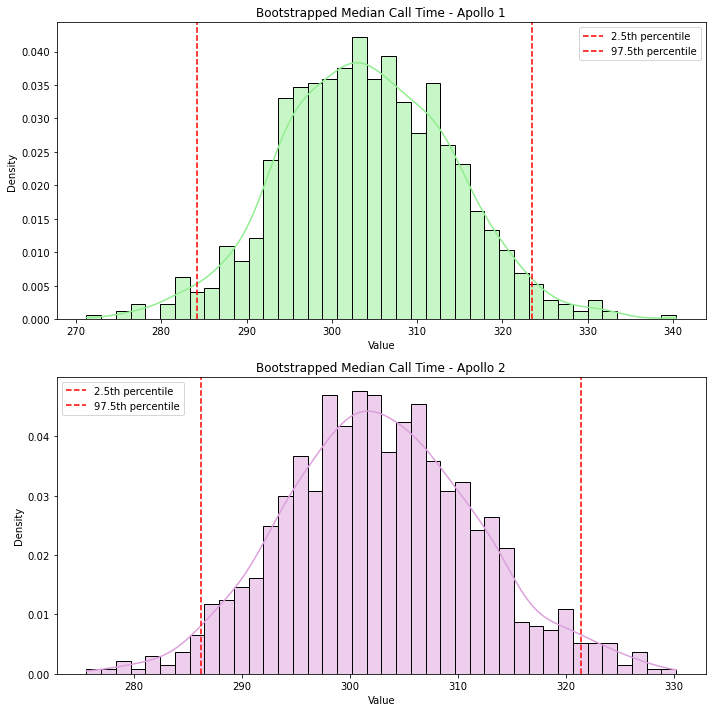

In [7]:
models = ['Apollo 1', 'Apollo 2']
colors = ['lightgreen', 'plum']
percentiles = [2.5, 97.5] 
bootstrapped_medians = bootstrap_statistics(df, 'model', 'call_time', models, stat_func=np.mean)
plot_subplots(bootstrapped_medians, models, colors, percentiles, 'Bootstrapped Median Call Time -')

In [8]:
pivoted_df = df.pivot_table(index='call_dt', columns='model', values='call_time', aggfunc='mean').reset_index(drop=False)

In [9]:
pivoted_df.sample(5)

model,call_dt,Apollo 1,Apollo 2
9,2024-01-10,315.653385,257.295213
12,2024-01-13,413.487731,227.281716
16,2024-01-17,255.610713,200.960177
5,2024-01-06,307.202179,372.713675
26,2024-01-27,274.459743,240.968391


In [10]:
columns_to_plot= ["Apollo 1","Apollo 2"]
new_labels = ["Apollo 1" , "Apollo 2"]

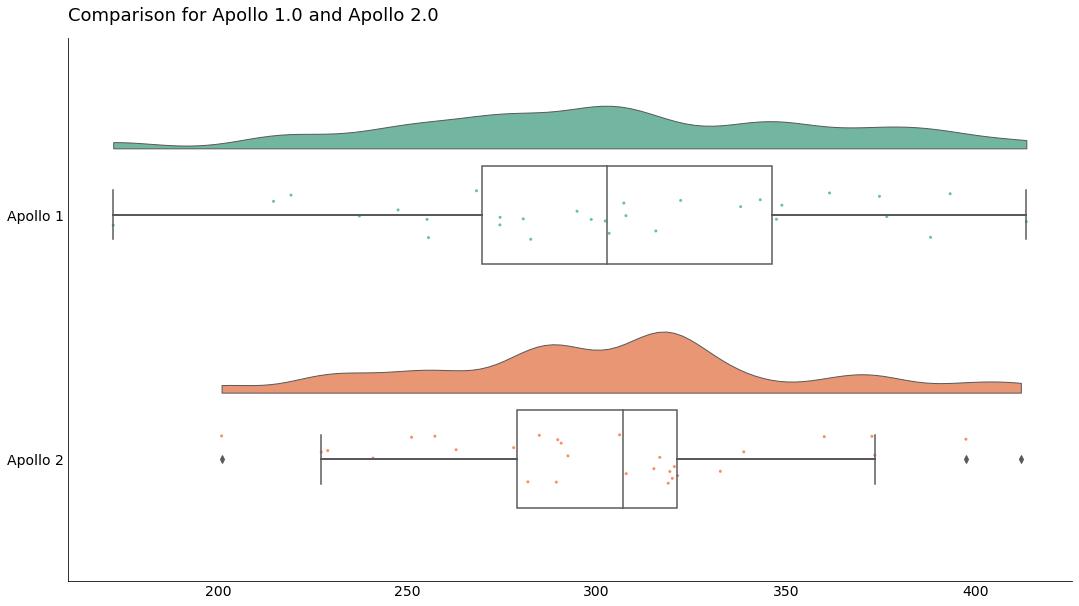

In [11]:
plot_transformed_data(pivoted_df, columns_to_plot, "Comparison for Apollo 1.0 and Apollo 2.0", new_labels=new_labels)